In [15]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt

## 1. Load Labeled Data
Load dataset yang telah memiliki label

In [3]:
df = pd.read_csv('../resources/data/labeled_question_list_all.csv')

In [4]:
df

,question,label,label_int
0,Internet mati nih,problem,2.0
1,Harga STB berapa ya?,information,0.0
2,Internet saya putus sambung,information,0.0
3,apakah untuk pergantian paket layanan bisa sek...,information,0.0
4,apakah jika saat proses pergantian paket layan...,information,0.0
...,...,...,...
1182,harga modem berapa?,information,0.0
1183,kapan mybiznet ada di appstore?,information,0.0
1184,Saya tidak bisa melakukan pembayaran melalui B...,information,0.0
1185,untuk promo biznet home ada apa saja?,information,0.0


## Train Data
Proses training data untuk mendapatkan model klasifikasi.
- Data training dan testing dibagi dalam perbandingan 80:20.
- Proses training diujikan ke dalam beberapa algoritma klasifikasi.

In [11]:
# set Feature and Target
X_text = df['question'].tolist()
y = df['label_int'].astype(int)

# embedding
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(X_text)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_embed, y, test_size=0.2, random_state=42, stratify=y
)

# training logistic regression
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# prediction 
y_pred = clf.predict(X_test)

# evaluation
report = classification_report(y_test, y_pred, target_names=['information', 'request', 'problem'])

In [12]:
print(report)

              precision    recall  f1-score   support

 information       0.97      0.99      0.98       204
     request       1.00      0.88      0.93        16
     problem       0.87      0.72      0.79        18

    accuracy                           0.96       238
   macro avg       0.94      0.86      0.90       238
weighted avg       0.96      0.96      0.96       238



## Evaluation
Dari hasil pengujian beberapa algoritma klasifikasi diatas dapat dilihat pada gambar dibawah. 

Bahwa algortima Logistic Regression memberikan performa terbaik berdasarkan nilai accuracy yang didapat.

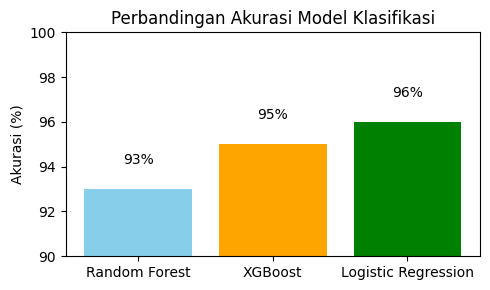

In [ ]:
# Data
model_list = ['Random Forest', 'XGBoost', 'Logistic Regression']
acc_list = [93, 95, 96]

# Plotting
plt.figure(figsize=(5, 3))
bars = plt.bar(model_list, acc_list, color=['skyblue', 'orange', 'green'])
plt.ylim(90, 100)
plt.ylabel('Akurasi (%)')
plt.title('Perbandingan Akurasi Model Klasifikasi')

# Tambahkan nilai akurasi di atas bar
for bar, acc in zip(bars, acc_list):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{acc}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Dalam pengujian over/under fitting, algoritma Logistic Regression memberikan hasil Best Fit dengan nilai accuracy pada data training 95% dan data testing 96%.

In [67]:
# Setelah training
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Akurasi training dan testing
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9505
Testing Accuracy: 0.9622


## Export Model

In [68]:
joblib.dump(clf, '../resources/model/trained_model.pkl')

['../resources/model/trained_model.pkl']

## Inference

In [18]:
# Load model klasifikasi
clf = joblib.load('../resources/model/trained_model.pkl')

# Load model BERT
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
def predict_label(question_text):
    # Lakukan embedding pertanyaan
    embedding = bert_model.encode([question_text])  # hasil shape (1, 384)

    # Prediksi label
    label_int = clf.predict(embedding)[0]
    label_prob = clf.predict_proba(embedding)[0]
    print('prob:', label_prob)

    # Mapping angka ke label string
    label_map = {
        0: 'information',
        1: 'request',
        2: 'problem'
    }

    return label_map.get(label_int, 'unknown')


In [20]:
text = "mau relokasi"
predicted_label = predict_label(text)

print(f"Prediksi label: {predicted_label}")

prob: [0.09723316 0.86369774 0.0390691 ]
Prediksi label: request
